1️⃣ Описание эксперимента

Мобильный продукт тестирует изменение в пользовательском пути.
Проверяется влияние новой механики на удержание пользователей.

Гипотеза:
Изменение пользовательского пути влияет на удержание пользователей.

Метрики:
Основная:
- retention_7

Дополнительные:
- retention_1
- sum_gamerounds (вовлечённость)

2️⃣ Загрузка и первичный обзор данных

In [2]:
import pandas as pd

df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
num_users = df['userid'].nunique()
print(f"Количество уникальных пользователей: {num_users}")

Количество уникальных пользователей: 90189


In [ ]:
"""
Датасет содержит достаточно большое количество наблюдений, что позволяет проводить статистический анализ с высокой мощностью теста.

Каждая строка соответствует одному пользователю, дубликатов пользователей не обнаружено.
"""

3️⃣ Проверка размера и баланса групп

In [5]:
df['version'].value_counts()

,count
version,
gate_40,45489
gate_30,44700


In [6]:
df.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


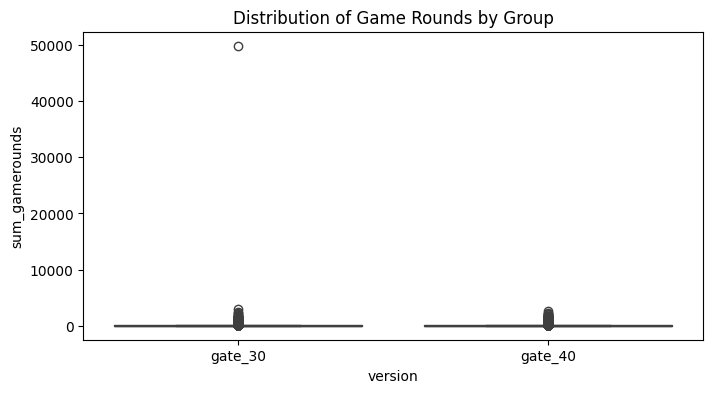

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.boxplot(x='version', y='sum_gamerounds', data=df)
plt.title('Distribution of Game Rounds by Group')
plt.show()

In [ ]:
"""
Размеры контрольной и тестовой групп сопоставимы

Распределение игровой активности асимметрично (характерно для игровых продуктов)

Медианные значения близки

Существенных различий между группами до эксперимента не выявлено

Рандомизация проведена корректно, эксперимент можно анализировать дальше.
"""

4️⃣ Расчёт retention по группам

In [9]:
retention_1_by_group = (
    df.groupby('version')['retention_1']
      .mean()
)

retention_1_by_group

,retention_1
version,
gate_30,0.448188
gate_40,0.442283


In [10]:
retention_7_by_group = (
    df.groupby('version')['retention_7']
      .mean()
)

retention_7_by_group

,retention_7
version,
gate_30,0.190201
gate_40,0.182000


In [ ]:
"""

В тестовой группе наблюдается снижение удержания пользователей как на 1-й, так и на 7-й день.

Снижение более выражено на 7-й день, что делает retention_7 ключевой метрикой для дальнейшего анализа.

"""

5️⃣ Абсолютная и относительная разница

In [11]:
abs_diff_retention_1 = (
    retention_1_by_group['gate_40']
    - retention_1_by_group['gate_30']
)

rel_diff_retention_1 = (
    abs_diff_retention_1
    / retention_1_by_group['gate_30']
)

In [12]:
print(f"Retention 1 day (control): {retention_1_by_group['gate_30']:.2%}")
print(f"Retention 1 day (test): {retention_1_by_group['gate_40']:.2%}")
print(f"Абсолютная разница: {abs_diff_retention_1:.2%}")
print(f"Относительная разница: {rel_diff_retention_1:.2%}")

Retention 1 day (control): 44.82%
Retention 1 day (test): 44.23%
Абсолютная разница: -0.59%
Относительная разница: -1.32%


In [13]:
abs_diff_retention_7 = (
    retention_7_by_group['gate_40']
    - retention_7_by_group['gate_30']
)

rel_diff_retention_7 = (
    abs_diff_retention_7
    / retention_7_by_group['gate_30']
)

In [14]:
print(f"Retention 7 day (control): {retention_7_by_group['gate_30']:.2%}")
print(f"Retention 7 day (test): {retention_7_by_group['gate_40']:.2%}")
print(f"Абсолютная разница retention_7: {abs_diff_retention_7:.2%}")
print(f"Относительная разница retention_7: {rel_diff_retention_7:.2%}")

Retention 7 day (control): 19.02%
Retention 7 day (test): 18.20%
Абсолютная разница retention_7: -0.82%
Относительная разница retention_7: -4.31%


In [ ]:
"""
Новая механика оказывает негативное влияние на удержание, особенно заметное на 7-й день.

Абсолютное снижение менее 1 п.п., однако относительное снижение превышает 4%, что может быть бизнес-значимым при большом масштабе продукта.
"""

6️⃣ Проверка статистической значимости (Chi-square)

retention_7

In [15]:
from scipy.stats import chi2_contingency

contingency_table7 = pd.crosstab(
    df['version'],
    df['retention_7']
)

contingency_table7

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [16]:
chi2, p_value_7, dof, expected = chi2_contingency(contingency_table7)
print(f"p-value (retention_7): {p_value_7:.5f}")

p-value (retention_7): 0.00160


In [ ]:
"""
Разница между контрольной и тестовой группами по retention_7 статистически значима (p < 0.05).

Вероятность получить такую разницу случайно составляет менее 0.2%.

Нулевая гипотеза отвергается.
"""

retention_1

In [17]:
contingency_table1 = pd.crosstab(
    df['version'],
    df['retention_1']
)

contingency_table1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [18]:
chi2, p_value_1, dof, expected = chi2_contingency(contingency_table1)
print(f"p-value (retention_1): {p_value_1:.5f}")

p-value (retention_1): 0.07550


In [ ]:
"""
Разница по retention_1 не является статистически значимой.

Наблюдаемое снижение может быть следствием случайных колебаний.
"""

In [ ]:
"""
Новая механика значимо ухудшает 7-day retention.

Однако не оказывает статистически подтверждённого влияния на 1-day retention.
"""

7️⃣ Доверительные интервалы (bootstrap)

In [19]:
import numpy as np

def bootstrap_ci(data, n_bootstrap=5000, ci=0.95):
    boot_means = []

    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_means.append(sample.mean())

    lower = np.percentile(boot_means, (1 - ci) / 2 * 100)
    upper = np.percentile(boot_means, (1 + ci) / 2 * 100)

    return lower, upper

In [20]:
control = df[df['version'] == 'gate_30']['retention_7'].astype(int)
test = df[df['version'] == 'gate_40']['retention_7'].astype(int)

ci_control = bootstrap_ci(control)
ci_test = bootstrap_ci(test)

ci_control, ci_test

((np.float64(0.18664429530201343), np.float64(0.19378131991051453)),
 (np.float64(0.1785046934423707), np.float64(0.18556134450086834)))

In [21]:
def bootstrap_diff_ci(control, test, n_bootstrap=5000, ci=0.95):
    diffs = []

    for _ in range(n_bootstrap):
        c_sample = np.random.choice(control, size=len(control), replace=True)
        t_sample = np.random.choice(test, size=len(test), replace=True)
        diffs.append(t_sample.mean() - c_sample.mean())

    lower = np.percentile(diffs, (1 - ci) / 2 * 100)
    upper = np.percentile(diffs, (1 + ci) / 2 * 100)

    return lower, upper

In [22]:
ci_diff = bootstrap_diff_ci(control, test)
ci_diff

(np.float64(-0.013327129569343477), np.float64(-0.0031907400800931162))

In [ ]:
"""
Доверительные интервалы контрольной и тестовой групп практически не пересекаются

0 не входит в доверительный интервал разницы

Это подтверждает, что негативный эффект устойчив и реален, а не обусловлен случайным шумом.
"""

8️⃣ Проверка устойчивости результата (удаление 1%)

In [23]:
df['sum_gamerounds'].describe()

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


In [24]:
threshold = df['sum_gamerounds'].quantile(0.99)
df_trimmed = df[df['sum_gamerounds'] <= threshold]

In [25]:
contingency_trimmed = pd.crosstab(
    df_trimmed['version'],
    df_trimmed['retention_7']
)

chi2_t, p_value_t, _, _ = chi2_contingency(contingency_trimmed)
p_value_t

np.float64(0.001157630723934999)

In [ ]:
"""
Для проверки устойчивости результатов мы исключили 1% пользователей
с наибольшим числом игровых раундов.

После удаления этих выбросов результат A/B-теста сохранился.
Это означает, что негативный эффект новой механики не обусловлен поведением небольшой группы сверхактивных пользователей и является устойчивым.
"""

В рамках A/B-теста была оценена новая механика пользовательского пути в мобильной игре.

Анализ показал, что в тестовой группе 7-day retention снизился на 0.82 п.п. (−4.31% относительно контроля).

Разница является статистически значимой (χ², p = 0.0016) и подтверждается доверительными интервалами.

Проверка устойчивости результатов после удаления 1% наиболее активных пользователей показала сохранение эффекта.

Рекомендация: **не выкатывать новую механику в текущем виде.**